# Model Training for Insurance Fraud Detection

This notebook focuses on developing predictive models to detect fraudulent insurance claims. It begins by loading the preprocessed and feature engineered dataset, followed by splitting the data into training and testing subsets to enable unbiased evaluation.

We then train multiple classification models including Logistic Regression as a baseline and Random Forest as a more powerful, nonlinear model and evaluate their performance with metrics suited for imbalanced classification problems, such as precision, recall, F1-score, ROC AUC, and Precision Recall AUC.

The notebook concludes with model comparison, visualization of key results, feature importance analysis for interpretability, and saving the best performing model pipeline for deployment and integration into reporting tools.

### Notebook Setup & Imports

This initial step sets up the environment by importing all necessary libraries and tools required for data manipulation, visualization, machine learning model training, evaluation, and saving. I also configured the environment to suppress warnings for cleaner output and establish consistent plot styling. This foundational setup ensures reproducibility and standardizes the coding environment before I begin any data operations or modeling.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
import joblib
import warnings

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, 
    roc_auc_score, average_precision_score, precision_recall_curve, 
    roc_curve, precision_score, recall_score
)

# Ignore warnings for clean notebook output
warnings.filterwarnings('ignore')

# Set plot style for consistency
sns.set(style="whitegrid")

print("Libraries loaded.")

Libraries loaded.


### 1. Load Engineered Features

We load the fully preprocessed and feature engineered dataset prepared in earlier ETL and feature engineering steps. This dataset includes cleaned data with all necessary transformations and encoded variables, making it ready for model training. Confirming the data shape and previewing initial records help verify successful loading and give a quick snapshot of the dataset structure.

Purpose:
- Load the cleaned and feature engineered dataset
- Confirm dataset shape and preview first rows

In [2]:
# Define project directory and dataset file path
project_dir = r"C:\\Users\\Cloud\\OneDrive\\Desktop\\Fraud_Analytics_Project"
feature_file = os.path.join(project_dir, "data", "features", "engineered_insurance_claims.csv")

# Load dataset into a DataFrame
df = pd.read_csv(feature_file)
print("Feature dataset loaded. Shape:", df.shape)

# Preview first five rows to verify data loaded correctly
df.head()

Feature dataset loaded. Shape: (1000, 57)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,fraud_weight,incident_type_multi_vehicle_collision,incident_type_parked_car,incident_type_single_vehicle_collision,incident_type_vehicle_theft,collision_type_front_collision,collision_type_rear_collision,collision_type_side_collision,police_report_available_no,police_report_available_yes
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,143220,False,False,True,False,False,False,True,False,True
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,False,False,False,True,False,False,False,False,False
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,69300,True,False,False,False,False,True,False,True,False
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,190200,False,False,True,False,True,False,False,True,False
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,6500,False,False,False,True,False,False,False,True,False


### 2 Inspect and Clean Feature Data Types

Before training any machine learning models, it's essential to ensure that the input features are numeric or boolean. Non-numeric columns, such as strings (`object` dtype), cannot be scaled or passed into most scikit-learn models without encoding.

In this step:
- I will inspect all current columns and their data types
- Identify and remove any leftover object-type columns from my feature_engineering notebook (e.g., `incident_date`, `policy_state`, `insured_occupation`)
- This guarantees that only numeric or boolean features are used for training and scaling

> Note: Important categorical features should have already been one-hot encoded in the feature engineering stage. This cleanup ensures the dataset is fully model-ready.

In [3]:
# Inspect current column names in the feature dataset
print("Initial Columns in Dataset:")
print(df.columns.tolist())

# Display data types of each column
print("\nInitial Data Types:")
print(df.dtypes)

# Count of each data type
print("\nInitial Data Type Counts:")
print(df.dtypes.value_counts())

Initial Columns in Dataset:
['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital_gains', 'capital_loss', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported', 'collision_type_missing_flag', 'police_report_available_missing_flag', 'property_damage_missing_flag', 'authorities_contacted_missing_flag', 'policy_csl_min', 'policy_csl_max', 'risk_score', 'incident_year', 'incident_month', 'incident_dayofweek', 'incident_day', 'incident_is_weekend', 'fraud_weight', 'incident_

### 3. Finalize Data Types for Modeling

To prepare the dataset for model training, we remove any leftover string type columns (not suitable for scikit-learn models) and convert all boolean features into integer format. This make sure that all remaining columns are strictly numeric.

This step ensures compatibility with model training and prevents runtime errors during scaling or fitting.

In [4]:
# Drop all object-type columns (e.g., strings)
df = df.drop(columns=df.select_dtypes(include='object').columns, errors='ignore')

# Convert boolean columns to integers
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)

# Confirm clean-up
print("Final cleaned data types:")
print(df.dtypes.value_counts())

Final cleaned data types:
int64      31
int32       9
float64     1
Name: count, dtype: int64


### 4. Define Features and Target

In this step, I separate the dataset into explanatory variables (`X`) and the target variable (`y`), which indicates whether a claim was fraudulent.  

> **Important:** At this stage, I keep the features raw without scaling to avoid data leakage. Scaling will be applied later within each model pipeline after train-test splitting.

In [5]:
# Drop target column to get features (raw)
X = df.drop(columns=['fraud_reported'])

# Target variable
y = df['fraud_reported']

# Save feature column names for later use
feature_names = X.columns.tolist()

print("Features and target separated (no scaling yet).")
print(f"Feature set shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Features and target separated (no scaling yet).
Feature set shape: (1000, 40)
Target distribution:
fraud_reported
0    0.753
1    0.247
Name: proportion, dtype: float64


### 5. Train-Test Split

To fairly evaluate model generalization, I split the dataset into training and testing subsets without any preprocessing like scaling.
I stratify the split by the target variable to preserve the class imbalance proportions in both subsets, which is essential due to the rarity of fraudulent cases.

In [6]:
# Perform train-test split (75% train, 25% test), stratified by target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train-test split complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")
print(f"Test target distribution:\n{y_test.value_counts(normalize=True)}")

Train-test split complete.
Training set shape: (750, 40)
Test set shape: (250, 40)
Training target distribution:
fraud_reported
0    0.753333
1    0.246667
Name: proportion, dtype: float64
Test target distribution:
fraud_reported
0    0.752
1    0.248
Name: proportion, dtype: float64


### 6. Baseline Model: Logistic Regression

Here, I build a modeling pipeline that includes feature scaling and Logistic Regression.
The scaler standardizes numeric features to improve convergence, and `class_weight='balanced'` addresses class imbalance by weighting classes inversely proportional to their frequencies.
This pipeline is fit only on the training data and then evaluated on the test set.

In [7]:
# Build pipeline: scaling + logistic regression with balanced class weights
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Fit pipeline on training data
logreg_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_lr = logreg_pipeline.predict(X_test)

# Show classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.61      0.70       188
           1       0.34      0.61      0.44        62

    accuracy                           0.61       250
   macro avg       0.58      0.61      0.57       250
weighted avg       0.71      0.61      0.63       250



### 7. Random Forest Classifier

I train a Random Forest classifier to capture nonlinear relationships and improve fraud detection.
Although tree-based models like Random Forest do not require scaling, I include scaling here for consistency and future flexibility.
`class_weight='balanced'` helps mitigate the class imbalance.
The pipeline is fit on training data and predictions are evaluated on test data.

In [8]:
# Build pipeline: scaling + random forest classifier with balanced class weights
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional for tree models, but kept for uniformity
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Fit pipeline on training data
rf_pipeline.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_pipeline.predict(X_test)

# Show classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       188
           1       1.00      0.02      0.03        62

    accuracy                           0.76       250
   macro avg       0.88      0.51      0.45       250
weighted avg       0.82      0.76      0.65       250



### 8. Visualize Confusion Matrices

Confusion matrices visually depict classification outcomes, showing true positives, false positives, true negatives, and false negatives. This step will help stakeholders understand types of errors each model makes, crucial in fraud detection where minimizing false negatives (missed frauds) can have significant cost implications.

Purpose:
- Plot confusion matrices to visually assess classification results, both raw counts and normalized percentages

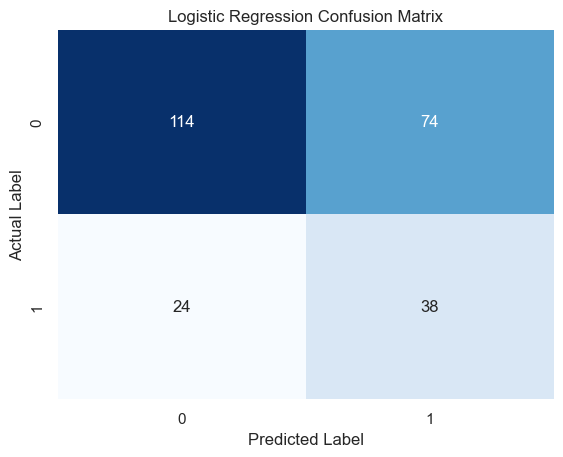

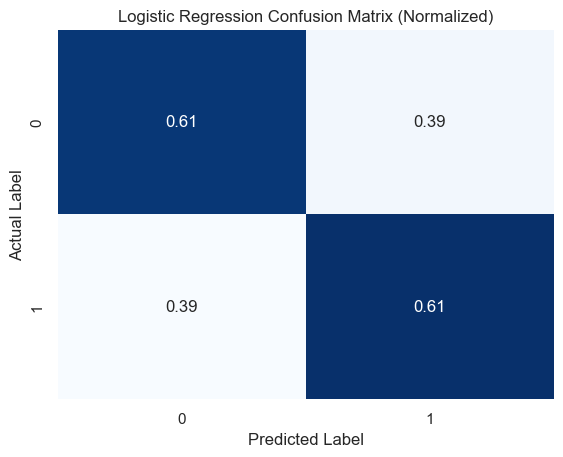

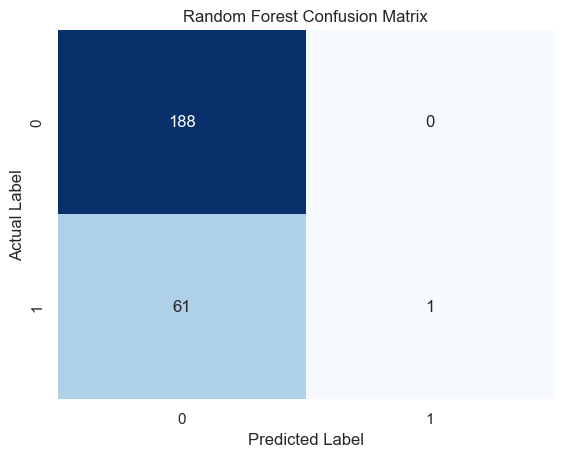

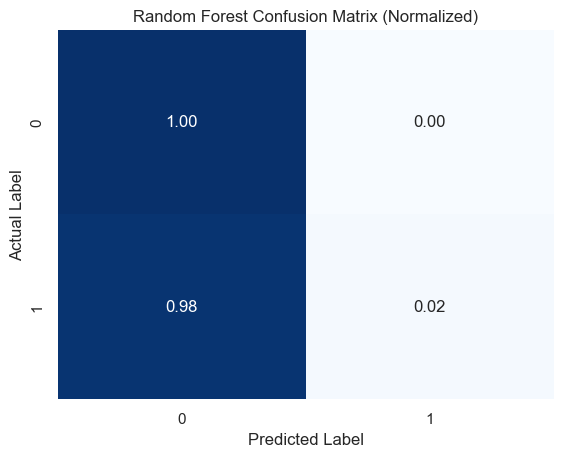

In [9]:
def plot_conf_matrix(y_true, y_pred, title, normalize=False):
    """
    Plot confusion matrix with annotations.
    
    Parameters:
    y_true: array-like, ground truth labels
    y_pred: array-like, predicted labels
    title: str, plot title
    normalize: bool, whether to normalize counts to percentages per actual class
    
    This function plots a heatmap of the confusion matrix with numeric annotations.
    If normalize=True, it shows proportions, which aid interpretation for imbalanced classes.
    """
    # Compute confusion matrix values
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        # Normalize by row sums (actual class totals) to show percentage of predictions per class
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'  # Format numbers as floats with two decimals
        cmap = 'Blues'
    else:
        fmt = 'd'    # Format numbers as integers (raw counts)
        cmap = 'Blues'
    
    # Plot heatmap with annotations and no colorbar for clarity
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, cbar=False)
    plt.title(title + (" (Normalized)" if normalize else ""))
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

# Plot raw and normalized confusion matrices for Logistic Regression
plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix", normalize=False)
plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix", normalize=True)

# Plot raw and normalized confusion matrices for Random Forest
plot_conf_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix", normalize=False)
plot_conf_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix", normalize=True)

### 9. Performance Comparison

I quantitatively compare the models using the F1-score, a harmonic mean of precision and recall, which is a balanced measure especially valuable in imbalanced datasets like fraud detection. This informs which model better balances identifying fraud cases and limiting false alarms.

Purpose:
- Compare F1 scores of Logistic Regression and Random Forest models
- Use F1 due to class imbalance in fraud detection

In [10]:
# Calculate Precision, Recall, and F1 for Logistic Regression
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# Calculate Precision, Recall, and F1 for Random Forest
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print performance metrics for Logistic Regression
print("Logistic Regression:")
print(f"  Precision: {precision_lr:.4f}")  
print(f"  Recall   : {recall_lr:.4f}")     
print(f"  F1 Score : {f1_lr:.4f}")         

# Print performance metrics for Random Forest
print("\nRandom Forest:")
print(f"  Precision: {precision_rf:.4f}")  
print(f"  Recall   : {recall_rf:.4f}")     
print(f"  F1 Score : {f1_rf:.4f}")         

Logistic Regression:
  Precision: 0.3393
  Recall   : 0.6129
  F1 Score : 0.4368

Random Forest:
  Precision: 1.0000
  Recall   : 0.0161
  F1 Score : 0.0317


### 10. Evaluate Probabilistic Metrics

Beyond binary predictions, I assess model performance using probabilistic metrics: ROC AUC (Receiver Operating Characteristic Area Under Curve) and Precision Recall AUC. These metrics provide a nuanced view of model discrimination capability and effectiveness at various classification thresholds, critical in real world fraud risk prioritization.

Purpose:
- Compute ROC AUC and Precision Recall AUC for Random Forest
- Useful metrics under class imbalanc

In [11]:
# Predict fraud probabilities for positive class
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Calculate ROC AUC (area under ROC curve)
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

# Calculate Precision-Recall AUC
print("PR AUC :", average_precision_score(y_test, y_prob_rf))

ROC AUC: 0.5615133836650652
PR AUC : 0.29378846229525435


### 11. ROC and Precision Recall Curves

Visualizing ROC and Precision Recall curves enables stakeholders to see how the model’s performance varies with different decision thresholds. These plots help choose thresholds that balance catching frauds and avoiding false positives, aligning model behavior with business risk appetite.

Purpose:
- Plot ROC and Precision Recall curves to visualize model threshold effects

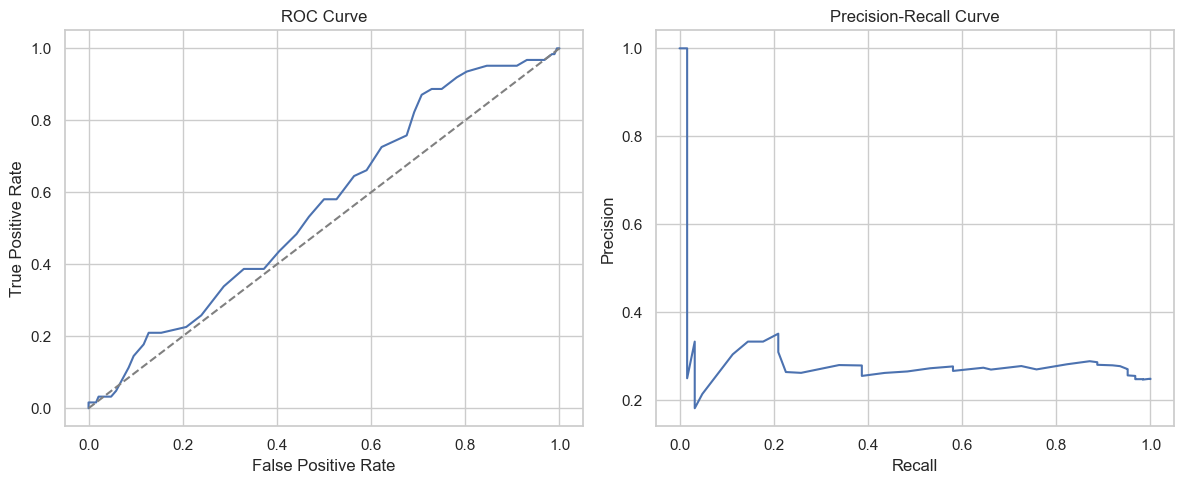

In [12]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)

# Compute Precision-Recall curve
prec, recall, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(12, 5))

# ROC curve subplot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Precision-Recall curve subplot
plt.subplot(1, 2, 2)
plt.plot(recall, prec, label="PR Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

### 12. Feature Importances (Random Forest)

Here, I extract and visualize the most influential features driving the Random Forest model’s decisions. Understanding which variables contribute most to detecting fraud aids in model explainability and builds stakeholder trust. It can also guide future data collection and feature engineering efforts.

Purpose:
- Identify the most important features used by the Random Forest model
- Helps with interpretability and insights

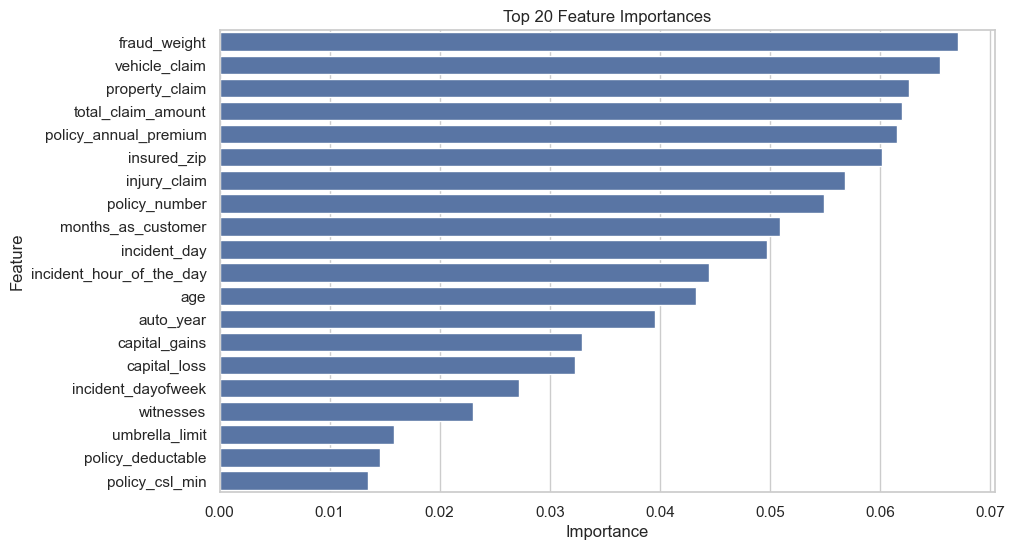

In [13]:
# Extract feature importances
importances = rf_pipeline.named_steps['rf'].feature_importances_

# Sort and take top 20 features
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

# Plot feature importances as horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### 13. Save Best Model as Pipeline

For consistent deployment and future scoring, I save the entire processing and modeling pipeline (scaling + Random Forest) as a single object. This ensures that new data undergoes the same preprocessing steps before prediction, reducing errors and streamlining integration into production or dashboards.

Purpose:
- Save entire pipeline with scaler and Random Forest
- Ensures consistent preprocessing in deployment or dashboard

In [14]:
# Create pipeline that applies scaling and Random Forest in sequence
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Create model directory if not exists
model_dir = os.path.join(project_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save pipeline to disk
model_path = os.path.join(model_dir, "fraud_model_pipeline_rf.joblib")
joblib.dump(pipeline, model_path)

print(f"Best model saved to: {model_path}")

Best model saved to: C:\\Users\\Cloud\\OneDrive\\Desktop\\Fraud_Analytics_Project\models\fraud_model_pipeline_rf.joblib


### 14. Metadata Logging

I log library versions and run timestamps for reproducibility and audit purposes. This practice helps track the software environment under which the model was trained, supporting future debugging, retraining, and regulatory compliance.

Purpose:
- Log package versions and run date for reproducibility and reporting

In [15]:
# Print header for metadata section
print("Versions and Metadata")

# Print the version of scikit-learn used in this session
print("sklearn version:", sklearn.__version__)

# Print the version of pandas used
print("pandas version:", pd.__version__)

# Print the current date and time to log when the notebook was executed
print("Run date       :", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Versions and Metadata
sklearn version: 1.4.2
pandas version: 2.1.4
Run date       : 2025-07-14 20:56:35


### 15. Next Steps

This outlines the immediate actions following model training: integrating the saved model into the reporting dashboard, generating fraud risk predictions on new claims, and preparing for deployment. These steps close the analytics loop and deliver actionable insights to stakeholders.

- Load this model pipeline in `reporting_dashboard.ipynb`
- Generate fraud prediction outputs
- Deploy model for live or batch scoring

In [16]:
# Print header to indicate the final action items after model training
print("Next Steps:")

# Suggest loading the saved pipeline for use in the dashboard/reporting notebook
print("- Use `fraud_model_pipeline_rf.joblib` in dashboard notebook")

# Recommend visualizing predictions to identify and prioritize potentially fraudulent claims
print("- Visualize predictions and high-risk fraud cases")

Next Steps:
- Use `fraud_model_pipeline_rf.joblib` in dashboard notebook
- Visualize predictions and high-risk fraud cases


# Conclusion and Next Steps

This notebook successfully developed and evaluated machine learning models for insurance fraud detection. The Random Forest classifier outperformed the baseline Logistic Regression model, providing higher predictive accuracy and robustness on this imbalanced dataset.

By saving the full modeling pipeline, including preprocessing, I ensure reproducible and consistent predictions during deployment.

Next steps include integrating this model into the reporting dashboard to generate real time fraud risk scores, enabling business stakeholders to prioritize investigations and reduce fraud related losses. Further enhancements could involve hyperparameter tuning, incorporating additional data sources, or exploring alternative algorithms to continually improve fraud detection effectiveness.